In [2]:
import torch 
from hnet.train.hnet import train_hnet
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from hnet.models.MLP import MLP 
from hnet.models.HyperNet import HyperNet
from hnet.train.hnet import EnergyDistanceLoss 
from sklearn.metrics import roc_auc_score


In [3]:
affinity = pd.read_csv('../../extdata/jglaser/jglaser_affinity_data.csv')
affinity.head()

,drug_idx,prot_idx,affinity,partition
0,470468,4590,0.691712,train
1,924073,20847,-2.054668,train
2,931582,5211,0.725847,train
3,207941,11556,-0.842542,train
4,145222,21072,0.145386,train


In [4]:
z_drug = torch.load('../../extdata/jglaser/z_drug.pt')
z_prot = torch.load('../../extdata/jglaser/z_prot.pt')
print(z_drug.shape, z_prot.shape)

/tmp/ipykernel_6104/2126589512.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z_drug = torch.load('../../extdata/jglaser/z_drug.pt')


torch.Size([980310, 768]) torch.Size([22974, 1024])


/tmp/ipykernel_6104/2126589512.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  z_prot = torch.load('../../extdata/jglaser/z_prot.pt')


In [5]:
train = affinity[lambda x: x.partition == 'train'] 
drug_idx_train = torch.tensor(train.drug_idx.values, dtype=torch.long)
prot_idx_train = torch.tensor(train.prot_idx.values, dtype=torch.long)
y_train = torch.tensor(train.affinity.values, dtype=torch.float32)

test = affinity[lambda x: x.partition == 'test'] 
drug_idx2 = torch.tensor(test.drug_idx.values, dtype=torch.long)
prot_idx2 = torch.tensor(test.prot_idx.values, dtype=torch.long)
y_test = torch.tensor(test.affinity.values, dtype=torch.float32)

n_val = int(len(y_test)*0.1) 
val_idx = np.random.choice(len(y_test), n_val, replace=False)
test_idx = np.setdiff1d(np.arange(len(y_test)), val_idx)

y_val = y_test[val_idx]
y_test = y_test[test_idx]

drug_idx_val = drug_idx2[val_idx]
prot_idx_val = prot_idx2[val_idx]

drug_idx_test = drug_idx2[test_idx]
prot_idx_test = prot_idx2[test_idx]


In [6]:
def eval(model, device, nsamples=100, batch_size=5000): 

    splits = torch.split(torch.arange(y_val.size(0)), batch_size)
    yhats = [] 
    for j,idx in enumerate(splits): 
        print(f'[batch:{j}/{len(splits)}]', end='\r')

        with torch.no_grad():
            didx = drug_idx_val[idx]
            pidx = prot_idx_val[idx]
            xx = torch.cat([z_drug[didx], z_prot[pidx]], dim=1).to(device)

            yhats.append( model(xx, samples=nsamples).cpu() ) 

    yhat_test = torch.cat(yhats, dim=1)

    r = np.corrcoef(yhat_test.mean(dim=0).numpy().ravel(), y_val.numpy().ravel())[0,1]
    r2 = r2_score(y_val.numpy().ravel(), yhat_test.mean(dim=0).numpy().ravel())

    return r, r2

In [7]:
use_cuda = True 
nsamples = 100
batch_size= 5000
lr=1e-4
num_epochs=200
negative_sampling=False

mlp_kwargs = {'in_channels': z_drug.shape[1] + z_prot.shape[1], 
              'hidden_channels': 256, 
              'out_channels': 1, 
              'layers': 3}

hnet_kwargs = {'stochastic_channels': 4, 
               'width':256} 

In [8]:
device = 'cuda' if (torch.cuda.is_available() and use_cuda) else 'cpu'

mlp = MLP(**mlp_kwargs)
model = HyperNet(mlp, **hnet_kwargs).to(device)

optim = torch.optim.Adam(model.parameters(), lr=lr)

crit = EnergyDistanceLoss()
mrl = torch.nn.MarginRankingLoss(margin=0)

In [9]:
torch.cuda.empty_cache()

losses = []
r2s = []
aucs = []
best_r2 = -np.inf
best_state = None
val_r2s = [] 
for i in range(num_epochs): 

    batch_loss = []
    batch_r2 = []
    batch_auc = []
    splits = torch.split(torch.randperm(y_train.size(0)), batch_size)
    for j,idx in enumerate(splits): 

        didx = drug_idx_train[idx]
        pidx = prot_idx_train[idx]
        xx = torch.cat([z_drug[didx], z_prot[pidx]], dim=1).to(device)
        yy = y_train[idx].to(device).unsqueeze(1)

        optim.zero_grad()
        yhat_pos = model(xx, samples=nsamples)

        loss1 = crit(yhat_pos, yy)
        
        batch_loss.append(loss1.item())
        r2 = r2_score(yy.detach().cpu().numpy(), yhat_pos.mean(dim=0).detach().cpu().numpy())
        batch_r2.append(r2)

        if negative_sampling: 
            # sample random idxs to inflate the negative samples 
            didx = torch.randint(0, z_drug.size(0), (yy.size(0),))
            pidx = torch.randint(0, z_prot.size(0), (yy.size(0),))
            xx = torch.cat([z_drug[didx], z_prot[pidx]], dim=1).to(device)
            yhat_neg = model(xx, samples=nsamples)
            loss2 = mrl(yhat_pos, yhat_neg, torch.ones_like(yhat_pos))
            auc = roc_auc_score(np.concatenate([np.ones_like(yhat_pos.mean(1).squeeze().detach().cpu().numpy()), np.zeros_like(yhat_neg.mean(1).squeeze().detach().cpu().numpy())]),
                                        np.concatenate([yhat_pos.mean(1).squeeze().detach().cpu().numpy(), yhat_neg.mean(1).squeeze().detach().cpu().numpy()]))
            batch_auc.append(auc)
        else: 
            loss2 = 0
            batch_auc.append(-1)
            auc = -1
        
        loss = loss1 + loss2
        loss.backward()
        optim.step()

        print(f'[batch:{j}/{len(splits)}]->{loss.item():.2f},{r2:.2f},{auc:.2f}', end='\r')

    losses.append(np.mean(batch_loss))
    r2s.append(np.mean(batch_r2))
    aucs.append(np.mean(batch_auc))

    r_val, r2_val = eval(model, device)
    val_r2s.append(r2_val)

    if r2_val > best_r2: 
        best_r2 = r2_val
        best_state = model.state_dict()

    print(f'--------> epoch: {i}/{num_epochs} --> loss: {losses[-1]:.3f}, R2: {r2s[-1]:.3f}, AUC: {aucs[-1]:.3f} || val r: {r_val:.3f}, val r2: {r2_val:.3f}')
    torch.save(model, 'model.pt')

--------> epoch: 0/200 --> loss: 2.403, R2: -110.283, AUC: -1.000 || val r: 0.336, val r2: -0.002
--------> epoch: 1/200 --> loss: 1.008, R2: 0.198, AUC: -1.000 || val r: 0.408, val r2: 0.113
--------> epoch: 2/200 --> loss: 0.954, R2: 0.282, AUC: -1.000 || val r: 0.461, val r2: 0.204
--------> epoch: 3/200 --> loss: 0.910, R2: 0.344, AUC: -1.000 || val r: 0.481, val r2: 0.208
--------> epoch: 4/200 --> loss: 0.873, R2: 0.391, AUC: -1.000 || val r: 0.501, val r2: 0.243
--------> epoch: 5/200 --> loss: 0.842, R2: 0.430, AUC: -1.000 || val r: 0.515, val r2: 0.257
--------> epoch: 6/200 --> loss: 0.814, R2: 0.464, AUC: -1.000 || val r: 0.528, val r2: 0.266
--------> epoch: 7/200 --> loss: 0.791, R2: 0.492, AUC: -1.000 || val r: 0.535, val r2: 0.285
--------> epoch: 8/200 --> loss: 0.768, R2: 0.519, AUC: -1.000 || val r: 0.544, val r2: 0.288
--------> epoch: 9/200 --> loss: 0.748, R2: 0.541, AUC: -1.000 || val r: 0.559, val r2: 0.311
--------> epoch: 10/200 --> loss: 0.733, R2: 0.559, AUC:

KeyboardInterrupt: 

In [10]:
best_r2

0.38129758834838867

In [11]:
model.load_state_dict(best_state)
torch.save(model, 'model.pt')

In [12]:
torch.cuda.empty_cache()

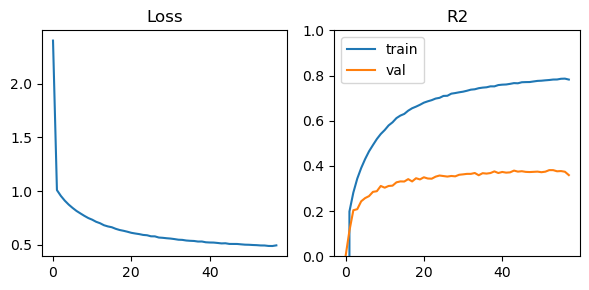

In [14]:
f,axes = plt.subplots(1,2, figsize=(6,3))
axes[0].plot(losses)
axes[0].set_title('Loss')
axes[1].plot(r2s, label='train')
axes[1].plot(val_r2s, label='val')
axes[1].legend()
axes[1].set_title('R2')
axes[1].set_ylim(0,1)
plt.tight_layout()
plt.show()

In [ ]:
model = torch.load('model.pt')
device = 'cuda' 

/tmp/ipykernel_4640/3227936466.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model.pt')


In [ ]:

# test evaluation 
def eval2(): 

    nsamples = 250
    batch_size = 5000

    splits = torch.split(torch.arange(y_test.size(0)), batch_size)
    yhats = [] 
    for j,idx in enumerate(splits): 
        print(f'[batch:{j}/{len(splits)}]', end='\r')

        with torch.no_grad():
            didx = drug_idx_test[idx]
            pidx = prot_idx_test[idx]
            xx = torch.cat([z_drug[didx], z_prot[pidx]], dim=1).to(device)
            yy = y_test[idx].to(device).unsqueeze(1)

            yhats.append( model(xx, samples=nsamples).cpu() ) 

    yhat_test = torch.cat(yhats, dim=1)

    r = np.corrcoef(yhat_test.mean(dim=0).numpy().ravel(), y_test.numpy().ravel())[0,1]
    r2 = r2_score(y_test.numpy().ravel(), yhat_test.mean(dim=0).numpy().ravel())

    return r, r2, yhat_test

In [ ]:
r, r2, yhat_test = eval2()

print(f'Pearson (Test): {r:.3f}')
print(f'R2 (Test): {r2:.3f}')

Pearson (Test): 0.625
R2 (Test): 0.372


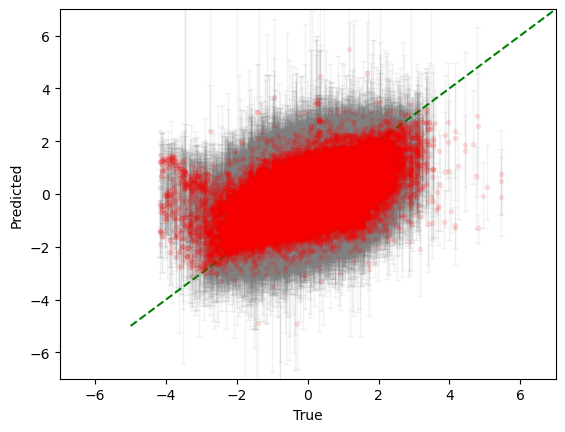

In [ ]:
ql = 0.025
qu = 0.975
yhat_lower = yhat_test.quantile(ql, dim=0).squeeze().numpy()
yhat_upper = yhat_test.quantile(qu, dim=0).squeeze().numpy()
yhat_mean = yhat_test.mean(dim=0).squeeze().numpy()

plt.figure()
#plt.plot(y_test.numpy(), yhat_mean, 'r.', alpha=0.01)
plt.errorbar(y_test.numpy(), yhat_mean, yerr=[np.abs(yhat_mean - yhat_lower), np.abs(yhat_upper - yhat_mean)], fmt='r.', alpha=0.1, ecolor='gray', elinewidth=1, capsize=2)
plt.plot((-5, 7), (-5, 7), 'g--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.ylim(-7, 7)
plt.xlim(-7, 7)
plt.show()

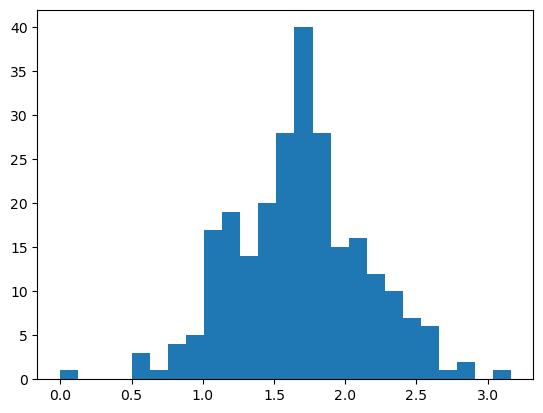

In [ ]:
plt.figure()
plt.hist(yhat_test[:,0],bins=25)
plt.show()

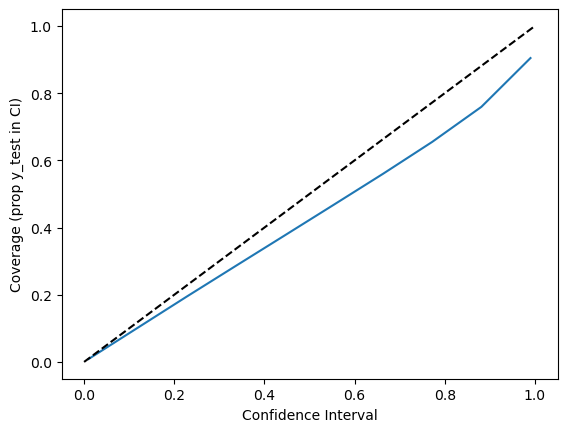

In [ ]:
prop = []; cii = []
for ci in np.linspace(0.01, 0.99, 10):
    cii.append(ci)
    ql = (1-ci)/2
    qu = 1 - ql 
    lcb, ucb = yhat_test.quantile(torch.tensor([ql, qu], dtype=torch.float32), dim=0).squeeze()
    prop.append( ((y_test > lcb) & (y_test < ucb)).float().mean() ) 

plt.figure()
plt.plot(cii, prop)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Confidence Interval')
plt.ylabel('Coverage (prop y_test in CI)')
plt.show()

In [ ]:
torch.cuda.empty_cache()

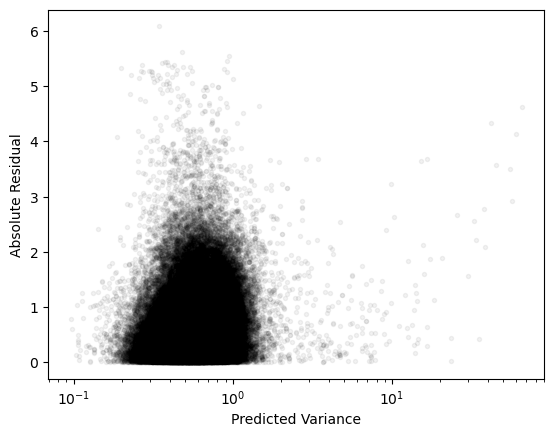

In [ ]:
resid = y_test.numpy().ravel() - yhat_test.mean(dim=0).numpy().ravel()
pred_var = yhat_test.var(dim=0).numpy().ravel()

plt.figure()
plt.plot(yhat_test.std(dim=0).numpy(), np.abs(resid), 'k.', alpha=0.05)
plt.xlabel('Predicted Variance')
plt.ylabel('Absolute Residual')
plt.xscale('log')
plt.show()
